In [1]:
import numpy as np
import os
from scipy import ndarray

import skimage as sk
from skimage import transform
from skimage import util
from skimage import io
import imageio

from numpy import linalg as LA
from scipy.sparse import csc_matrix,coo_matrix
from scipy.sparse.linalg import svds, eigs
from sklearn.decomposition import PCA,TruncatedSVD
import pickle
import pandas as pd
from random import randint
import random

import umap
from sklearn.manifold import TSNE
from sklearn.cluster import DBSCAN, KMeans, AffinityPropagation, MeanShift
from sklearn.preprocessing import MinMaxScaler
import kmapper as km
from kmapper.cover import Cover
from sklearn.datasets import fetch_mldata
from sklearn.decomposition import PCA
import hdbscan
import sklearn.cluster as cluster
from sklearn.metrics import adjusted_rand_score, adjusted_mutual_info_score

import networkx as nx
from community import best_partition # this is not part of networkx

import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
from matplotlib.colors import ListedColormap
from scipy import ndimage
import imageio
import plotly
import plotly.graph_objs as go

from pandas import DataFrame

def bbox(img):
    rows = np.any(img, axis=1)
    cols = np.any(img, axis=0)
    rmin, rmax = np.where(rows)[0][[0, -1]]
    cmin, cmax = np.where(cols)[0][[0, -1]]

    return rmin, rmax, cmin, cmax    
def embedding(data,dim):
    projection = mapper.fit_transform(data, projection=umap.UMAP(n_components=dim, n_neighbors=200, 
                                             a=None, angular_rp_forest=False, b=None, init='spectral',
                                           learning_rate=1.0, local_connectivity=1.0, metric='euclidean',
                                           metric_kwds=None, min_dist=0.1, n_epochs=500,
                                           negative_sample_rate=10, random_state=47,
                                           repulsion_strength=1.0, set_op_mix_ratio=0.5, spread=0.25,
                                           target_metric='categorical', target_metric_kwds=None,
                                           target_n_neighbors=-1, target_weight=0.5, transform_queue_size=10.0,
                                           transform_seed=42, verbose=False))
    return projection

def random_rotation(image_array):
    # pick a random degree of rotation between 25% on the left and 25% on the right
    random_degree = random.uniform(-25, 25)
    return sk.transform.rotate(image_array, random_degree)

def rotation(image_array, degree):
    return sk.transform.rotate(image_array, degree)

def random_noise(image_array):
    # add random noise to the image
    return sk.util.random_noise(image_array)

def horizontal_flip(image_array):
    # horizontal flip doesn't need skimage, it's easy as flipping the image array of pixels !
    return image_array[:, ::-1]

def bbox(img):
    rows = np.any(img, axis=1)
    cols = np.any(img, axis=0)
    rmin, rmax = np.where(rows)[0][[0, -1]]
    cmin, cmax = np.where(cols)[0][[0, -1]]

    return rmin, rmax, cmin, cmax    

def pad_with(vector, pad_width, iaxis, kwargs):
    pad_value = kwargs.get('padder', 0)
    vector[:pad_width[0]] = pad_value
    vector[-pad_width[1]:] = pad_value
    
def augmentation(folder_path,augmented_folder_path,num_unique_cells,angle_step):
    images = [os.path.join(folder_path, f) for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f))]
    for cell in range(num_unique_cells):
        path = '%s/cell_%s' % (augmented_folder_path,cell)
        if not os.path.isdir(path): 
            os.mkdir(path)
        else:
            pass

#         print('Augmenting cell '+str(cell)+' in '+folder_path)
        image_path = images[cell]
        img = imageio.imread(image_path)
        rmin, rmax, cmin, cmax = bbox(img)
        image_to_transform = np.pad(img[rmin:rmax,cmin:cmax], 2, pad_with, padder=0)  

        rotation_angle = 0
        transformed_image = None
        while rotation_angle < 360:
            transformed_image = rotation(image_to_transform, rotation_angle)
            new_file_path = '%s/cell_%s/angle_%s.jpg' % (augmented_folder_path,cell,rotation_angle)
            io.imsave(new_file_path, transformed_image)
            transformed_image = horizontal_flip(transformed_image)
            new_file_path = '%s/cell_%s/angle_%s_flipped.jpg' % (augmented_folder_path,cell,rotation_angle)
            io.imsave(new_file_path, transformed_image)
            rotation_angle += angle_step

In [3]:
'''Loading the new data'''
numb_new_cells = 5
directory = '/home/garner1/Work/dataset/cellImages/image52/augmented'
'''Box each nucleus'''
cell_labels = []
images = []
count = 0
total = 0
Mwidths = 47  #based on fully augmented labeled images
Mheights = 55 #based on fully augmented labeled images
for cell in os.listdir(directory)[:numb_new_cells]:
    path = os.path.join(directory, cell)
    for filename in os.listdir(path):
        img = imageio.imread(os.path.join(path, filename))
        rmin, rmax, cmin, cmax = bbox(img)
        width = rmax-rmin
        height = cmax-cmin
        total += 1
        if width <= Mwidths:
            if height <= Mheights:
                padwidth = int(Mwidths-(rmax-rmin))
                padheight = int(Mheights-(cmax-cmin))
                newimg = np.pad(img[rmin:rmax,cmin:cmax],((0,padwidth),(0,padheight)),'constant', constant_values=(0))
                images.append(newimg)
#                 print cell
#                 print filename.split('.')
                cell_labels.append((cell,filename.split('.')[0]))
                count += 1
            
print count, total, len(cell_labels)

3608 3608 3608


In [4]:
X_new = np.zeros((len(images),Mwidths*Mheights))
for ind in range(len(images)): 
    X_new[ind,:] = images[ind].flatten() # from 2D arrays to 1D arrays
    
print X_new.shape

(3608, 2585)


In [8]:
n_neighbors = 100
n_components = 3
%time trans = umap.UMAP(n_neighbors=n_neighbors,min_dist=0.0,n_components=n_components,random_state=42).fit(X_new)
'''3D visualization of annotated data'''
clusterer = hdbscan.HDBSCAN(min_samples=None,min_cluster_size=100)
clusterer.fit(trans.embedding_)

import plotly.graph_objects as go

fig = go.Figure()
size = 1
for cluster in set(clusterer.labels_):
    clustered = (clusterer.labels_ == cluster)
    fig.add_trace(go.Scatter3d(
        x=trans.embedding_[clustered,0],  # <-- Put your data instead
        y=trans.embedding_[clustered,1],  # <-- Put your data instead
        z=trans.embedding_[clustered,2],  # <-- Put your data instead
        name="cluster "+str(cluster),
        mode="markers",
        marker=dict(color=clusterer.labels_,size=size, opacity=1)
    ))
fig.update_layout(title_text="HDBSCAN clusters in 3D ",title_font_size=30)
fig.show()
##########
clustered = (clusterer.labels_ >= 0)
print('The percentage of clustered data points is '+str(np.sum(clustered) *1.0/ len(clustered)*100)+'%')


CPU times: user 18.3 s, sys: 5.14 s, total: 23.4 s
Wall time: 13.6 s


The percentage of clustered data points is 93.43126385809313%


CPU times: user 16.6 s, sys: 3.87 s, total: 20.5 s
Wall time: 12.9 s


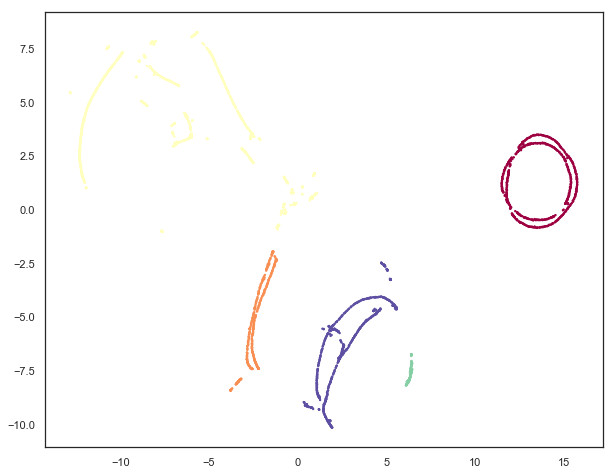

In [7]:
'''
HDBSCAN clusters in 2D
low min sample size seems to refuce unclustered data;
larger min cluster size decrease cluster numbers
'''
n_neighbors = 100
n_components = 2
%time trans = umap.UMAP(n_neighbors=n_neighbors,min_dist=0.0,n_components=n_components,random_state=42).fit(X_new)
clusterer = hdbscan.HDBSCAN(min_samples=None,min_cluster_size=100)
clusterer.fit(trans.embedding_)
 
sns.set(style='white', rc={'figure.figsize':(10,8)})
clustered = (clusterer.labels_ >= 0)
plt.scatter(trans.embedding_[~clustered, 0],
            trans.embedding_[~clustered, 1],
            c=(0.5, 0.5, 0.5),
            s=2,
            alpha=0.5)
plt.scatter(trans.embedding_[clustered, 0],
            trans.embedding_[clustered, 1],
            c=clusterer.labels_[clustered],
            s=2,
            cmap='Spectral');
# plt.scatter(trans.embedding_[:, 0],
#             trans.embedding_[:, 1],
#             c=clusterer.labels_,
#             s=2,
#             cmap='Spectral');

In [99]:
'''Need to better understand the order of cells and cluster labels'''
print cell_labels[:10]

List = zip(cell_labels,clusterer.labels_)

from collections import defaultdict
d = defaultdict(list)

for k, v in List: 
    d[k].append(v) #group the cluster_id by cell_id
print(tuple(d.items()))  #these are sorted by cell_id value

# from collections import Counter
cluster_id = []
for List in d.values():
    c = Counter(List)
    cluster_id.append(c.most_common(1)[0][0]) #these are sorted by cell_id value from 1 to numb_new_cells
# print cluster_id[:2]

[('cell_268', 'angle_298'), ('cell_268', 'angle_327'), ('cell_268', 'angle_70_flipped'), ('cell_268', 'angle_52'), ('cell_268', 'angle_152'), ('cell_268', 'angle_228_flipped'), ('cell_268', 'angle_134_flipped'), ('cell_268', 'angle_206'), ('cell_268', 'angle_211'), ('cell_268', 'angle_272')]


In [89]:
import csv
with open('/home/garner1/Work/dataset/cellImages/image52/properties.csv', 'r') as f:
    properties = list(csv.reader(f, delimiter=','))
properties = np.array(properties)

cell_labels = [int(i) for i in cell_labels]
image = imageio.imread('/home/garner1/Work/dataset/cellImages/image52/iMS266_20190426_001.sub52.jpg')
sns.set(style='white', rc={'figure.figsize':(50,30)})

plt.scatter(properties[cell_labels,1].astype(np.float)[clustered],
            properties[cell_labels,2].astype(np.float)[clustered],
            c=np.asarray(clusterer.labels_)[clustered],
            s=500,
            cmap='Spectral',
            alpha=0.9);
plt.imshow(image,cmap='gray')
plt.show()

TypeError: int() argument must be a string or a number, not 'tuple'